# Transfer Learning fundamentals

## 1) Concept
The idea of **transfer learning** is using a **pre-trained** model (a model that has been trained on a large dataset) from outside sources, **implement** it a bit, and apply on your problems. As a reminder, the early layers learn more abstract features than the laters. Therefore, when using transfer learning, we keep the early ones and modify the later one. Due to this fact can apply transfer learning on classes that were not trained on the pre-trained model. I will use a pre-trained convolutional network as an illustration for my transfer learning practice today.

A convolutional network consists of conv layers and dense layers. The conv layers in the pre-trained model are called **conv base**. Implementing a pre-trained model means replacing your dense layers and train the model in a way that does not affect the conv base weights too much. There are two popular implement methods: **feature extraction** and **fine tune**.

* Feature extraction: Only modify dense layers
* Fine-tune: modify the last few conv base layers

In the code below, I will use the fine-tune approach that involves tweaking the last conv layer

The goal is to use the pre-trained model **VGG19** to classify **Santa** or **not Santa**

## 2 Data and VGG19


The data includes 385 santa images and 447 not santa images that are divided into 3 folder 

* Train: 271 Images each

* Validation: 100 Images each

* Test: 90 Images each

In [87]:
train_folder = 'split/train'
test_folder = 'split/test'
val_folder = 'split/validation'

Santa


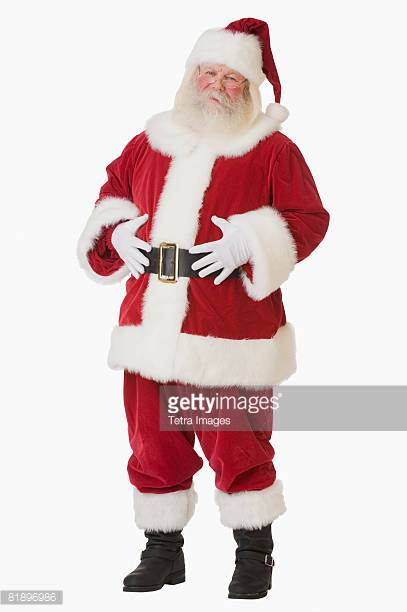

In [103]:
from IPython.display import Image
from IPython.display import display
x = Image(filename=train_folder+'/santa/00000011.jpg',width=300) 
y = Image(filename=train_folder+'/not_santa/00000001.jpg',width=300) 
print("Santa")
display(x)

Not Santa


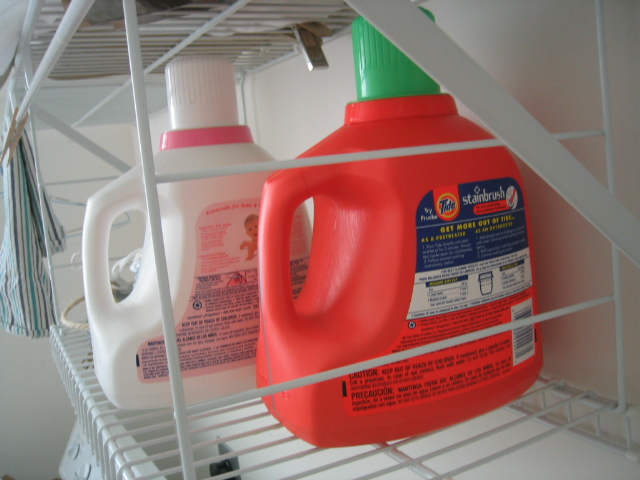

In [104]:
print("Not Santa")
display(y)

VGG-19 is a convolutional neural network that is 19 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. (has no santa)

In [86]:
from keras.applications import VGG19

#Exclude the dense layers and reshape from (224, 224 ,3) to (64, 64, 3)
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## 3) Action

In [78]:
# Add the dense layers to conv base
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential() #Sequential model
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [79]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 132)               270468    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 133       
Total params: 20,294,985
Trainable params: 270,601
Non-trainable params: 20,024,384
_________________________________________________________________


In [81]:
#Perform Data Augmentation with Image Data Generator
# Step 1: Define ImageDataGenerator object with different parameters
# Step 2: REPLACE the original image with 20 different images through data aug by flow_from_directory
# Note that we set "test set batch size" = "test set size"

from keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_folder,  
                                                    target_size=(64, 64),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,  
                                                                       target_size=(64, 64),  
                                                                       batch_size=20, 
                                                                       class_mode='binary')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,  
                                                                        target_size=(64, 64), 
                                                                        batch_size=180,
                                                                        class_mode='binary')

test_images, test_labels = next(test_generator)

Found 542 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


In [82]:
#Fine tune

#Step 1: Free cnn base
#Step 2: unfreeze the last conv layers in cnn

cnn_base.trainable = False
cnn_base.block5=True
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_6 True
dense_18 True
dense_19 True


In [83]:
history = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=10)

Epoch 1/10
28/28 [==============================] - 29s 1s/step - loss: 0.6654 - acc: 0.6015 - val_loss: 0.6127 - val_acc: 0.6850
Epoch 2/10
28/28 [==============================] - 32s 1s/step - loss: 0.6110 - acc: 0.7103 - val_loss: 0.6224 - val_acc: 0.7700
Epoch 3/10
28/28 [==============================] - 33s 1s/step - loss: 0.5678 - acc: 0.7823 - val_loss: 0.4688 - val_acc: 0.8350
Epoch 4/10
28/28 [==============================] - 33s 1s/step - loss: 0.5257 - acc: 0.8173 - val_loss: 0.5246 - val_acc: 0.8300
Epoch 5/10
28/28 [==============================] - 33s 1s/step - loss: 0.4962 - acc: 0.8432 - val_loss: 0.4710 - val_acc: 0.9100
Epoch 6/10
28/28 [==============================] - 33s 1s/step - loss: 0.4630 - acc: 0.8542 - val_loss: 0.3898 - val_acc: 0.8950
Epoch 7/10
28/28 [==============================] - 34s 1s/step - loss: 0.4470 - acc: 0.8653 - val_loss: 0.3641 - val_acc: 0.9150
Epoch 8/10
28/28 [==============================] - 36s 1s/step - loss: 0.4277 - acc: 0.86

In [91]:
# Accuracy on the test set
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

test acc: 0.894444465637207


# Some discovery

**Lemma**: `Sigmoid is a special case of softmax function`


Softmax for $K$ classes:

$$\operatorname{Pr}\left(Y_{i}=k\right)=\frac{e^{\boldsymbol{\beta}_{k} \cdot \mathbf{X}_{i}}}{\sum_{0 \leq c \leq K} e^{\boldsymbol{\beta}_{c} \cdot \mathbf{X}_{i}}}$$

where $\beta_k$ is a vector of weights (or regression coefficients) corresponding to outcome k.
When K=2, we have 

$\begin{aligned} \operatorname{Pr}\left(Y_{i}=0\right) &=\frac{e^{\beta_{0} \cdot \mathbf{X}_{i}}}{\sum_{0 \leq c \leq K} e^{\beta_{c} \cdot \mathbf{X}_{i}}}=\frac{e^{\beta_{0} \cdot \mathbf{X}_{i}}}{e^{\beta_{0} \cdot \mathbf{X}_{i}}+e^{\beta_{1} \cdot \mathbf{x}_{i}}}=\frac{e^{\left(\beta_{0}-\beta_{1}\right) \cdot \mathbf{X}_{i}}}{e^{\left(\beta_{0}-\beta_{1}\right) \cdot \mathbf{x}_{i}}+1}=\frac{e^{-\beta \cdot \mathbf{X}_{i}}}{1+e^{-\beta \cdot \mathbf{X}_{i}}} \\ \operatorname{Pr}\left(Y_{i}=1\right) &=\frac{e^{\beta_{1} \cdot \mathbf{X}_{i}}}{\sum_{0 \leq c \leq K} e^{\beta_{c} \cdot \mathbf{X}_{i}}}=\frac{e^{\beta_{1} \cdot \mathbf{x}_{i}}}{e^{\beta_{0} \cdot \mathbf{x}_{i}}+e^{\beta_{1} \cdot \mathbf{x}_{i}}}=\frac{1}{e^{\left(\beta_{0}-\beta_{1} \cdot \mathbf{x}_{i}\right)}+1}=\frac{1}{1+e^{-\beta \cdot \mathbf{x}_{i}}} \end{aligned}$ Q.E.D

Therefore, for a binary classification problem, in the output layer of a neural network, you can have either have a softmax with 2 units, or a sigmoid with 1 unit.
